In [1]:
%%capture
import pandas as pd
import numpy as np
from scipy.stats import bernoulli
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
!pip install qpsolvers
import qpsolvers
!pip install qpsolvers[cvxopt]
!pip install qpsolvers[open_source_solvers]
!pip install qpsolvers[clarabel]
from qpsolvers import solve_qp

In [2]:
raisin_whole = pd.read_csv('raisin.csv')
raisin_whole = raisin_whole.replace('Kecimen', 1)
raisin_whole = raisin_whole.replace('Besni', -1)
classes_to_keep = raisin_whole['Class'].copy()
raisin_whole = raisin_whole.drop(['Class'], axis=1)
cols = raisin_whole.columns.copy()
raisin_whole = StandardScaler().fit_transform(X=raisin_whole.to_numpy())
raisin_whole = pd.DataFrame(raisin_whole)
raisin_whole.columns = cols
raisin_whole['Class'] = classes_to_keep
raisin_data = raisin_whole.sample(frac=0.8)
list_train = raisin_data.index
list_test = []
for i in raisin_whole.index:
    if i not in list_train:
        list_test.append(i)
raisin_test = raisin_whole.filter(items=list_test, axis=0)

raisin_test = raisin_test.reset_index(drop=True)
raisin_data = raisin_data.reset_index(drop=True)
n_samples = raisin_data.shape[0]
n_samples_test = raisin_test.shape[0]

/tmp/ipykernel_8034/296143382.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  raisin_whole = raisin_whole.replace('Besni', -1)


In [3]:
def rbf(x,y,l=1):
    """Gaussian kernel

    Parameters
    -------------------------------
    x : float
    a real number

    y : float
    a real number

    l: float, non zero
    a scale parameter
    -------------------------------
    """
    dim = x.shape[0]
    vect = np.empty(dim)
    if dim == y.shape[0]  :
        d = np.exp((-1)*((np.linalg.norm(x-y))/(2*(l**2))))
        return d
    else :
        for i in range(dim):
            vect[i] = np.exp((-1)*(np.linalg.norm(x[i] - y))/(2*(l**2)))
        return vect

In [4]:
np.random.seed(1452234)
label = np.zeros(n_samples)
for i in range(n_samples):
    random = bernoulli.rvs(p=3/4)
    if raisin_data.loc[i,'Class'] == 1 and random == 0:
        label[i] = 1
    else:
        label[i] = -1
raisin_data['label'] = label

svm_train = SVC(kernel='sigmoid', probability = True,
                gamma=1).fit(X=raisin_data.to_numpy()[:,:-2],
                                  y=raisin_data.to_numpy()[:,-1])
probas = svm_train.predict_proba(raisin_data.to_numpy()[:,:-2])

In [5]:
proba_gap = probas[:,1] - probas[:,0]


raisin_data['proba_gap'] = proba_gap

n_min = 20

#in the article they fix n_min = 3

l_boundary = np.mean(np.sort(raisin_data[raisin_data['label'] == 1]['proba_gap'])[:n_min])


relab = np.empty(n_samples)
for i in range(n_samples):
    if raisin_data.loc[i,'proba_gap'] < l_boundary:
        relab[i] = -1
    elif raisin_data.loc[i,'label'] == 1 or raisin_data.loc[i,'proba_gap'] >= 0:
        relab[i] = 1
    else:
        relab[i] = 0
raisin_data['relab'] = relab

In [6]:
list_of_B = np.hstack((np.linspace(1,15,15,endpoint=True)))
performances = {}
for i in list_of_B:
    B = i
    labeled_data = raisin_data[raisin_data['relab'] != 0].copy()
    output_labeled = labeled_data['relab'].to_numpy()
    list_of_index = labeled_data.index
    labeled_data = labeled_data.reset_index(drop=True)
    labeled_data = labeled_data.to_numpy()[:,:-4]
    unlabeled_data = raisin_data.drop(index=list_of_index,axis=0)
    unlabeled_data = unlabeled_data.to_numpy()[:,:-4]
    n_unlabeled = unlabeled_data.shape[0]
    n_labels = labeled_data.shape[0]
    capital_k = np.zeros((n_labels,n_labels))
    kappa = np.zeros(n_labels)
    
    
    #construction of capital_k
    for i in range(n_labels):
        for j in range(i,n_labels):
            capital_k[i,j] = rbf(x=labeled_data[i,:],y=labeled_data[j,:])
    
    capital_k = capital_k + capital_k.T
    for i in range(n_labels):
        capital_k[i,i] = 1
    
    capital_k[np.where(np.isnan(capital_k) == True)] = 0
    
    #construction of kappa
    ratio_lab_unlab = n_labels/n_unlabeled
    
    for i in range(n_labels):
        vector = np.empty(n_unlabeled)
        for k in range(n_unlabeled):
            vector[k] = rbf(x=labeled_data[i,:],y=unlabeled_data[k,:])    
        kappa[i] = ratio_lab_unlab*np.sum(vector)
    
    kappa = -kappa
    
    
    
    ones_transposed = np.ones(n_labels).reshape(1,n_labels)
    a_mat = np.vstack((ones_transposed,ones_transposed*-1,
                       np.eye(n_labels),np.eye(n_labels)*-1))
    epsilon = (np.sqrt(n_labels)-1)/np.sqrt(n_labels)
    ub_mat = np.vstack((n_labels*(1+epsilon),n_labels*(epsilon-1),
                        np.ones(n_labels).reshape(n_labels,1)*B,
                        np.zeros(n_labels).reshape(n_labels,1)))
    
    
    
    beta_opti = solve_qp(P=capital_k,q=kappa,G=a_mat,h=ub_mat,solver='cvxopt')
    
    
    svm_weighted = SVC().fit(X=labeled_data,y=output_labeled,sample_weight=beta_opti)
    
    predictions_weighted = svm_weighted.predict(raisin_test.to_numpy()[:,:-1])
    
    positive = 0
    true_positive = 0
    for i in range(n_samples_test):
        if predictions_weighted[i] == 1:
            positive += 1
            if raisin_test.loc[i,'Class'] == 1:
                true_positive += 1
    
    precision_pgpu = true_positive/positive
    recall_pgpu = true_positive/raisin_test[raisin_test['Class'] == 1].shape[0]
    f_1_pgpu = (2*precision_pgpu*recall_pgpu)/(precision_pgpu+recall_pgpu)
    weird_estim_pgpu = (recall_pgpu**2)/(positive/raisin_test.shape[0])
    performances[f'{B}'] = [precision_pgpu, recall_pgpu,
                           f_1_pgpu, weird_estim_pgpu]

In [7]:
performances_df = pd.DataFrame(performances)

In [8]:
performances_df = performances_df.T

In [9]:
performances_df.columns = ['precision','recall','f_1','weird_estim']

Text(0.5, 1.0, 'weird_estim')

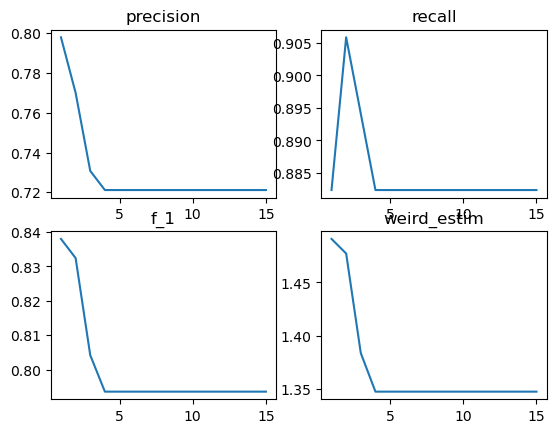

In [10]:
fig, axs = plt.subplots(2,2)
axs[0,0].plot(list_of_B,performances_df['precision'])
axs[0,0].set_title('precision')
axs[0,1].plot(list_of_B,performances_df['recall'])
axs[0,1].set_title('recall')
axs[1,0].plot(list_of_B,performances_df['f_1'])
axs[1,0].set_title('f_1')
axs[1,1].plot(list_of_B,performances_df['weird_estim'])
axs[1,1].set_title('weird_estim')

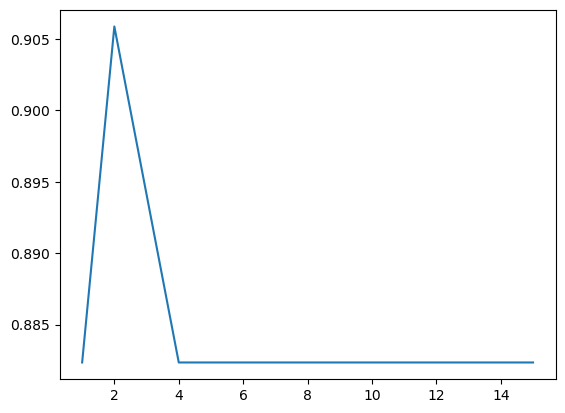

In [11]:
plt.plot(list_of_B,performances_df['recall'])

In [ ]:
#let's set B=2